In [1]:
pip install opencv-python numpy keras matplotlib pillow pyautogui

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.2 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.2 kB 217.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.2 kB 245.8 kB/s eta 0:00:01
     -------------------------------------- 61.2/61.2 kB 326.9 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (

In [73]:
import cv2
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [74]:
os.listdir(r"C:\Proj\ML\Media player\dataset")

['test', 'train']

In [75]:
os.listdir(r"C:\Proj\ML\Media player\dataset\train")


['01_palm',
 '02_fist',
 '03_thumbs-up',
 '04_thumbs-down',
 '05_index-right',
 '06_index-left',
 '07_no-gesture']

In [76]:
os.listdir(r"C:\Proj\ML\Media player\dataset\test")

['01_palm',
 '02_fist',
 '03_thumbs-up',
 '04_thumbs-down',
 '05_index-right',
 '06_index-left',
 '07_no-gesture']

In [77]:
import os
mode = input('Enter mode (train/test): ')
directory = os.path.join('C:\Proj\ML\Media player\dataset', mode, '')
print(directory)

<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\prade\AppData\Local\Temp\ipykernel_16208\207731696.py:3: SyntaxWarning: invalid escape sequence '\P'
  directory = os.path.join('C:\Proj\ML\Media player\dataset', mode, '')


Enter mode (train/test):  train


C:\Proj\ML\Media player\dataset\train\


In [4]:
# Import Libraries
import cv2
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import operator
import pyautogui
import time

In [79]:
cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    frame = cv2.flip(frame, 1)

    # Getting count of existing images
    count = {gesture: len(os.listdir(directory + gesture)) for gesture in os.listdir(directory) if os.path.isdir(directory + gesture)}
    
    # Print counts on the screen
    for i, (gesture, cnt) in enumerate(count.items()):
        cv2.putText(frame, f"{gesture}({i}): {cnt}", (10, 50 + i * 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 0, 0), 1)

    # Draw ROI
    x1 = int(0.5 * frame.shape[1])
    y1 = 10
    x2 = frame.shape[1] - 10
    y2 = int(0.5 * frame.shape[1])
    cv2.rectangle(frame, (x1-1, y1-1), (x2+1, y2+1), (255, 0, 0), 3)
    roi = cv2.resize(frame[y1:y2, x1:x2], (120, 120))
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, roi = cv2.threshold(roi, 130, 255, cv2.THRESH_BINARY)

    cv2.imshow("Collecting data", frame)
    cv2.imshow("ROI", roi)

    interrupt = cv2.waitKey(10)
    
    if interrupt & 0xFF == 27:  # ESC key
        break
    for i in range(7):
        if interrupt & 0xFF == ord(str(i)):
            cv2.imwrite(directory + f"{i:02d}/" + str(count[f"{i:02d}"]) + '.jpg', roi)

cap.release()
cv2.destroyAllWindows()

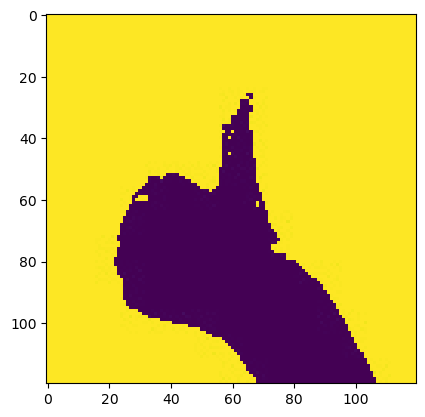

In [11]:
img = Image.open(r"C:\Proj\ML\Media player\dataset\train\03_thumbs-up\03_thumbs-up_15.jpg")
plt.imshow(img)

In [80]:
# Training CNN model
# Initialize the CNN
model = Sequential()

# First Convolution Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 1)))
model.add(MaxPooling2D((2, 2)))

# Second Convolution Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third Convolution Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flattening and Fully Connected Layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

C:\Users\prade\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
# Compiling the CNN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
# Preparing the train/test data with more augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalization
    shear_range=0.2,      # Shearing augmentation
    zoom_range=0.2,       # Zoom augmentation
    rotation_range=20,     # Rotation augmentation
    width_shift_range=0.2, # Horizontal shift
    height_shift_range=0.2,# Vertical shift
    horizontal_flip=False   # Horizontal flip
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

# Change the paths and target size as needed
training_set = train_datagen.flow_from_directory(
    r"C:\Proj\ML\Media player\dataset\train",
    target_size=(120, 120),  # Set target size as per model input
    batch_size=7,           # Increased batch size
    color_mode='grayscale',  # Using grayscale images
    class_mode='categorical' # Assuming more than two classes
)

test_set = test_datagen.flow_from_directory(
    r"C:\Proj\ML\Media player\dataset\test",
    target_size=(120, 120),  # Set target size as per model input
    batch_size=7,           # Increased batch size
    color_mode='grayscale',  # Using grayscale images
    class_mode='categorical' # Assuming more than two classes
)


Found 5465 images belonging to 7 classes.
Found 1815 images belonging to 7 classes.


In [83]:
# Training the model
batch_size =7  # Adjust based on your requirement

# Correctly set the steps_per_epoch
steps_per_epoch = len(training_set) // batch_size
validation_step = len(test_set) // batch_size
# Now, use this in your fit method
history = model.fit(training_set, steps_per_epoch=steps_per_epoch, epochs=10, validation_data=test_set, validation_steps=validation_step)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4389 - loss: 1.4086 - val_accuracy: 0.7568 - val_loss: 0.4066
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8611 - loss: 0.4061 - val_accuracy: 1.0000 - val_loss: 0.0263
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9071 - loss: 0.2532 - val_accuracy: 1.0000 - val_loss: 6.0281e-04
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9212 - loss: 0.2388 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9447 - loss: 0.1365 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9330 - loss: 0.1887 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9612 - loss: 0.1376 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0532 - val_

In [86]:
# Saving the model
model.save('handrecognition_model.hdf5')

In [87]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 118, 118, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       5,538,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,897,559 (64.46 MB)

 Trainable params: 5,632,519 (21.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,265,040 (42.97 MB)

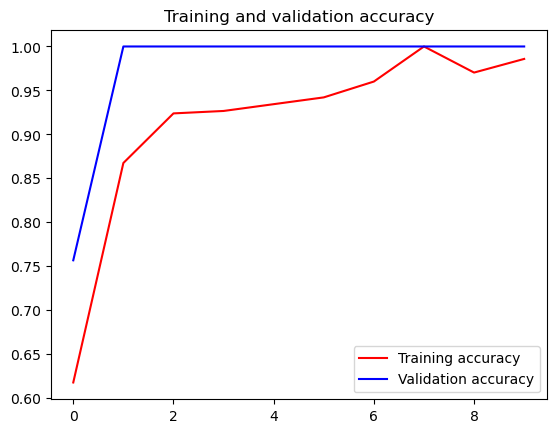

<Figure size 640x480 with 0 Axes>

In [84]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

<Figure size 640x480 with 0 Axes>

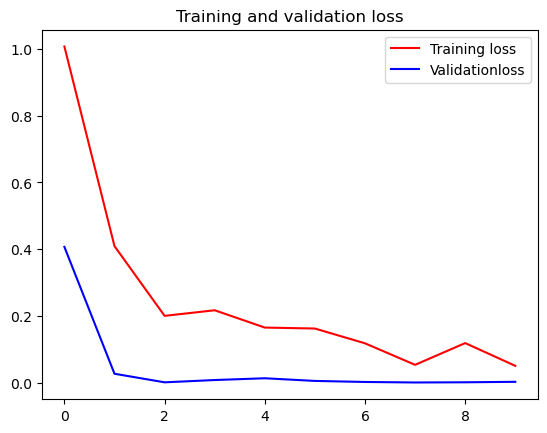

<Figure size 640x480 with 0 Axes>

In [85]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [89]:
# Save the model architecture to JSON
model_json = model.to_json()
with open("gesture-model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights with the correct filename
model.save_weights('gesture-model.weights.h5')


In [2]:
from keras.models import model_from_json

# Load model architecture from JSON file
with open("gesture-model.json", "r") as json_file:
    model_json = json_file.read()

# Create model from JSON
loaded_model = model_from_json(model_json)

# Load weights into the new model
loaded_model.load_weights("gesture-model.weights.h5")  # Change this line to match the saved weights file name
print("Loaded model from disk")


Loaded model from disk


C:\Users\prade\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
final_label = ""
action=""
vid = cv2.VideoCapture(0)
while (vid.isOpened()):

    ret,frame = vid.read()
    if ret:
            frame = cv2.flip(frame, 1)

            # Got this from collect-data.py
            # Coordinates of the ROI
            x1 = int(0.5*frame.shape[1])
            y1 = 10
            x2 = frame.shape[1]-10
            y2 = int(0.5*frame.shape[1])
            # Drawing the ROI
            # The increment/decrement by 1 is to compensate for the bounding box
            cv2.rectangle(frame, (x1-1, y1-1), (x2+1, y2+1), (255,0,0),3)
            # Extracting the ROI
            roi = frame[y1:y2, x1:x2]

            # Resizing the ROI so it can be fed to the model for prediction
            roi = cv2.resize(roi, (120, 120))
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            _, test_image = cv2.threshold(roi, 130, 255, cv2.THRESH_BINARY)
            cv2.imshow("Test Image", test_image)
            result = loaded_model.predict(test_image.reshape(1, 120, 120, 1))
            prediction = {'palm': result[0][0],
                          'fist': result[0][1],
                          'thumbs-up': result[0][2],
                          'thumbs-down': result[0][3],
                          'index-right': result[0][4],
                          'index-left': result[0][5],
                          'no-gesture':result[0][6]}
                # Sorting based on top prediction
            prediction = sorted(prediction.items(), key=operator.itemgetter(1), reverse=True)

            if(prediction[0][0] == 'palm'):
                final_label = 'palm'
                action = "PLAY/PAUSE"
                pyautogui.press('playpause', presses=1)
            elif (prediction[0][0] == 'fist'):
                final_label = 'fist'
                action = "MUTE"
                pyautogui.press('volumemute', presses=1)
            elif (prediction[0][0] == 'thumbs-up'):
                final_label = "thumbs-up"
                action = "VOLUME UP"
                pyautogui.press('volumeup', presses=1)
            elif (prediction[0][0] == "thumbs-down"):
                final_label = "thumbs-down"
                action = "VOLUME DOWN"
                pyautogui.press('volumedown', presses=1)
            elif (prediction[0][0] == "index-right"):
                final_label = "index-right"
                action = "FORWARD"
                pyautogui.press('nexttrack', presses=1)
            elif (prediction[0][0] == "index-left"):
                final_label = "index-left"
                action = "REWIND"
                pyautogui.press('prevtrack', presses=1)
            elif (prediction[0][0] == "no-gesture"):
                final_label = "no-gesture"
                action = "NO-ACTION"
            text1= "Gesture: {}".format(final_label)
            text2= "Action:{}".format(action)

            cv2.putText(frame, text1 , (10, 120), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,0,0), 1)
            cv2.putText(frame, text2 , (10, 220), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255,0,0), 1)
            cv2.imshow("Hand Gesture Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
vid.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━